In [1]:
import re
from wordcloud import WordCloud
import pandas as pd
from flask import request
from flasgger import Swagger, LazyString, LazyJSONEncoder
from flasgger import swag_from
from flask import Flask, jsonify
import sqlite3
import demoji
import emoji
from unidecode import unidecode
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
df_abussive = pd.read_csv('asset-challenges/abusive.csv')
df_abussive.head()

,ABUSIVE
0,alay
1,ampas
2,buta
3,keparat
4,anjing


In [3]:

df_kamusalay = pd.read_csv('asset-challenges/new_kamusalay.csv', header=None, names=['kata_alay', 'kata_baku'],encoding='latin-1')
df_kamusalay['kata_alay'] = df_kamusalay['kata_alay'].str.lower()
df_kamusalay['kata_baku'] = df_kamusalay['kata_baku'].str.lower()
df_kamusalay.head(1)

,kata_alay,kata_baku
0,anakjakartaasikasik,anak jakarta asyik asyik


In [4]:
df_data = pd.read_csv('asset-challenges/data.csv',encoding='utf-8')
df_data.head(1)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0


In [5]:
df_data.duplicated().sum()

125

--------------------------------------------------------------------------------------------------------------------------------

# Fungsi-fungsi

In [6]:
#fungsi untuk menghilangkan karakter
def clean_karakter(texts):
    tanpa_hex = [re.sub(r'\\x..', ' ', text) for text in texts]
    tanpa_backslash = [re.sub(r'\\', ' ', text) for text in tanpa_hex]
    tanpa_newline = [re.sub(r'\n', ' ', text) for text in tanpa_backslash]
    non_ascii = [re.sub(r'[^\x00-\x7F]+', ' ', text) for text in tanpa_newline]   
    non_url = [re.sub(r'https?://\S+|www\.\S+', ' ', text) for text in non_ascii]
    non_whitespace = [re.sub(r'\s+', ' ', text) for text in non_url]
    only_text = [re.sub(r'[^a-zA-Z0-9\s]', ' ', text) for text in non_whitespace]
    lower_text = [re.sub(r'[A-Z]', lambda x: x.group(0).lower(), text) for text in only_text]
    tanpa_kata_user = [re.sub(r'\buser\b', ' ', text) for text in lower_text]
    tanpa_kata_RT = [re.sub(r'\brt\b', ' ', text) for text in tanpa_kata_user]
    cleaned_text_new = [re.sub(r'\s+', ' ', text).strip() for text in tanpa_kata_RT]
    return cleaned_text_new

In [7]:
def remove_abusive(text):
    df_abusive = pd.read_csv('asset-challenges/abusive.csv')
    abusive_words = df_abusive['ABUSIVE'].tolist()
    abusive_words_lower = [word.lower() for word in abusive_words]
    for kata in abusive_words_lower:
        text = re.sub(r'\b' + re.escape(kata) + r'\b', '', text, flags=re.IGNORECASE)
    cleaned_text = re.sub(' +', ' ', text).strip()
    
    return cleaned_text

In [8]:
def replace_kata_alay(text, df_kamusalay):
    words = text.split()
    for i in range(len(words)):
        if words[i] in df_kamusalay['kata_alay'].values:
            new_word = df_kamusalay.loc[df_kamusalay['kata_alay'] == words[i], 'kata_baku'].values[0]
            words[i] = new_word
    return ' '.join(words)

Masukkan data ke database

In [9]:
def insert_data(text, cleaned_text):
    try: 
        conn_f = sqlite3.connect('asset-challenges/input_kalimat.db')       
        cursor_f = conn_f.cursor()    
        cursor_f.execute("INSERT INTO data_kalimat (text, cleaned_text) VALUES (?, ?)", (text, cleaned_text))
        conn_f.commit()
    except Exception as e:
        print(f"Error insert: {str(e)}")
    finally:
        conn_f.close()

In [10]:
def insert_data_file(text, cleaned_text, hs, abusive, hs_individual, hs_group, hs_religion, hs_race, hs_physical, hs_gender, hs_other, hs_weak, hs_moderate, hs_strong, alay_text):
    try:
        conn_f = sqlite3.connect('asset-challenges/input_file.db')
        cursor_f = conn_f.cursor()
        
        cursor_f.execute("""
            INSERT INTO data_kalimat_file (
                text, cleaned_text, hs, abusive, hs_individual, 
                hs_group, hs_religion, hs_race, hs_physical, hs_gender, 
                hs_other, hs_weak, hs_moderate, hs_strong, alay_text
            ) 
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?)
        """, (text, cleaned_text, hs, abusive, hs_individual, 
              hs_group, hs_religion, hs_race, hs_physical, hs_gender, 
              hs_other, hs_weak, hs_moderate, hs_strong,alay_text))
              
        conn_f.commit()
    except Exception as e:
        print(f"Error insert: {str(e)}")
    finally:
        conn_f.close()

# API

In [11]:
app = Flask(__name__)

app.json_encoder = LazyJSONEncoder
swagger_template = dict(
info = {
    'title': LazyString(lambda: 'API Documentation for Data Processing and Modeling'),
    'version': LazyString(lambda: '1.0.0'),
    'description': LazyString(lambda: 'Dokumentasi API untuk Data Processing dan Modeling'),
    },
    host = LazyString(lambda: request.host)
)

swagger_config = {
    "headers": [],
    "specs": [
        {
            "endpoint": 'api',
            "route": '/api.json',
        }
    ],
    "static_url_path": "/flasgger_static",
    "swagger_ui": True,
    "specs_route": "/api/"
}


swagger = Swagger(app, template=swagger_template,             
                  config=swagger_config)


# input kalimat
@swag_from("C://Users/akung/api/text_processing.yml", methods=['POST'])
@app.route('/text-processing', methods=['POST'])
def text_processing():

    text = request.form.get('text')

    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    cleaned_text = re.sub(' +', ' ', cleaned_text).strip()
    cleaned_text = replace_kata_alay(cleaned_text, df_kamusalay)
    cleaned_text = remove_abusive(cleaned_text)
    
    insert_data(text, cleaned_text)

    
    json_response = {
        'status_code': 200,
        'description': "Teks yang sudah diproses",
        'data': cleaned_text,
    }

    response_data = jsonify(json_response)
    return response_data


#input file
@swag_from("C://Users/akung/api/text_processing_file.yml", methods=['POST'])
@app.route('/text-processing-file', methods=['POST'])
def text_processing_file():

    file = request.files.getlist('file')[0]
    df_file = pd.read_csv(file,encoding='utf-8')
    df_file = df_file.drop_duplicates()
    
    texts_file = df_file['Tweet'].to_list()  
    hs_file = df_file['HS'].to_list()
    abusive_file = df_file['Abusive'].to_list()
    hs_individual_file = df_file['HS_Individual'].to_list()
    hs_group_file = df_file['HS_Group'].to_list()
    hs_religion_file = df_file['HS_Religion'].to_list()
    
    hs_race_file = df_file['HS_Race'].to_list()
    hs_physical_file = df_file['HS_Physical'].to_list()
    hs_gender_file = df_file['HS_Gender'].to_list()
    hs_other_file = df_file['HS_Other'].to_list()
    hs_weak_file = df_file['HS_Weak'].to_list()
    
    hs_moderate_file = df_file['HS_Moderate'].to_list()
    hs_strong_file = df_file['HS_Strong'].to_list()    
       

    alay_text = clean_karakter(texts_file)
    cleaned_text_new  = [replace_kata_alay(text, df_kamusalay) for text in alay_text]
    
    for i in range(len(cleaned_text_new)):
        cleaned_text_new[i] = remove_abusive(cleaned_text_new[i])
    
    for i in range(len(texts_file)):
        insert_data_file(texts_file[i], cleaned_text_new[i], hs_file[i], abusive_file[i], hs_individual_file[i], 
                         hs_group_file[i], hs_religion_file[i], hs_race_file[i], hs_physical_file[i], hs_gender_file[i], 
                         hs_other_file[i], hs_weak_file[i], hs_moderate_file[i], hs_strong_file[i], alay_text[i])
    
    json_response = {
        'status_code': 200,
        'description': "Teks yang sudah diproses",
        'data': cleaned_text_new,
    }
    response_data = jsonify(json_response)
    return response_data

if __name__ == '__main__':
   app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [04/Dec/2023 17:31:06] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [04/Dec/2023 17:31:06] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [04/Dec/2023 17:31:10] "GET /api/ HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2023 17:31:11] "GET /flasgger_static/lib/jquery.min.js HTTP/1.1" 304 -
127.0.0.1 - - [04/Dec/2023 17:31:11] "GET /flasgger_static/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [04/Dec/2023 17:31:11] "GET /flasgger_static/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [04/Dec/2023 17:31:11] "GET /flasgger_static/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [04/Dec/2023 17:31:11] "GET /api.json HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2023 17:31:29] "POST /text-processing HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2023 17:34:37] "POST /text-processing-file HTTP/1.1" 200 -


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Database

membuat table untuk input kalimat

In [12]:
conn = sqlite3.connect('asset-challenges/input_kalimat.db')
cursor = conn.cursor()
cursor.execute("DROP TABLE data_kalimat")
cursor.close()
conn.close()

In [13]:
conn = sqlite3.connect('asset-challenges/input_kalimat.db')
cursor = conn.cursor()
cursor.execute('''CREATE TABLE data_kalimat(id INTEGER PRIMARY KEY AUTOINCREMENT, text TEXT, cleaned_text TEXT)''')
print('Sukses buat table')
cursor.close()
conn.close()

Sukses buat table


In [14]:
conn = sqlite3.connect('asset-challenges/input_kalimat.db')
cursor = conn.cursor()
#test insert
cursor.execute("INSERT INTO data_kalimat (text, cleaned_text) VALUES (?, ?)", ('test kalimat', 'test kalimat bersih'))
conn.commit()
print('sukses')
cursor.close()
conn.close()

sukses


In [15]:
conn = sqlite3.connect('asset-challenges/input_kalimat.db')
cursor = conn.cursor()
#cek isi data
cursor.execute("SELECT * FROM data_kalimat")
hasil = cursor.fetchall()

print(hasil)
cursor.close()
conn.close()

[(1, 'test kalimat', 'test kalimat bersih')]


--------------------------------------------------------------------------------------------------------------------------------

Membuat table untuk input file

In [16]:
conn = sqlite3.connect('asset-challenges/input_file.db')
cursor = conn.cursor()
cursor.execute("DROP TABLE data_kalimat_file")
conn.commit()
cursor.close()
conn.close()

In [17]:
conn = sqlite3.connect('asset-challenges/input_file.db')
cursor = conn.cursor()

cursor.execute('''
    CREATE TABLE data_kalimat_file (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        text TEXT,
        cleaned_text TEXT,
        hs INTEGER,
        abusive INTEGER,
        hs_individual INTEGER,
        hs_group INTEGER,
        hs_religion INTEGER,
        hs_race INTEGER,
        hs_physical INTEGER,
        hs_gender INTEGER,
        hs_other INTEGER,
        hs_weak INTEGER,
        hs_moderate INTEGER,
        hs_strong INTEGER,
        alay_text TEXT
    );
''')

print('Sukses')
conn.commit()
cursor.close()
conn.close()

Sukses


In [18]:
conn = sqlite3.connect('asset-challenges/input_file.db')
cursor = conn.cursor()
#cek isi data
cursor.execute("SELECT cleaned_text FROM data_kalimat_file LIMIT 10")
hasil = cursor.fetchall()
print(hasil)
cursor.close()
conn.close()

[]


In [19]:
conn = sqlite3.connect('asset-challenges/input_file.db')
cursor = conn.cursor()
#cek isi data
cursor.execute("DELETE FROM data_kalimat_file")
conn.commit()
cursor.close()
conn.close()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# ANALISIS DATA

In [20]:
df_data_an = pd.read_csv('asset-challenges/data.csv',encoding='utf-8')
df_abussive_an = pd.read_csv('asset-challenges/abusive.csv')
df_kamusalay_an = pd.read_csv('asset-challenges/new_kamusalay.csv', header=None, names=['kata_alay', 'kata_baku'],encoding='latin-1')
df_data_an.head(1)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0


In [21]:
df_data_an.head(5)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [22]:
df_data_an.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


In [23]:
df_data_an.duplicated().sum()

125

In [24]:
df_data_an.isna().sum() / len(df_data_an)

Tweet            0.0
HS               0.0
Abusive          0.0
HS_Individual    0.0
HS_Group         0.0
HS_Religion      0.0
HS_Race          0.0
HS_Physical      0.0
HS_Gender        0.0
HS_Other         0.0
HS_Weak          0.0
HS_Moderate      0.0
HS_Strong        0.0
dtype: float64

In [25]:
#hapus Duplikat
df_data_an = df_data_an.drop_duplicates()
df_data_an.shape

(13044, 13)

In [26]:
#menghgapus karakter yang tidak dibutuhkan
tweets_list = df_data_an['Tweet'].tolist()
cleaned_tweets_list = clean_karakter(tweets_list)
df_data_an['Tweet'] = cleaned_tweets_list
df_data_an['Tweet'].head()

0    disaat semua cowok berusaha melacak perhatian ...
1    siapa yang telat ngasih tau elu edan sarap gue...
2    41 kadang aku berfikir kenapa aku tetap percay...
3    aku itu aku n nku tau matamu sipit tapi diliat...
4    kaum cebong kapir udah keliatan dongoknya dari...
Name: Tweet, dtype: object

- Data memiliki 13.169  baris dengan duplikat sebanyak 125 sehingga menyisakan 13.044 baris
- Jumlah kolom sebanyak 13
- Data tidak memiliki nilai missing value

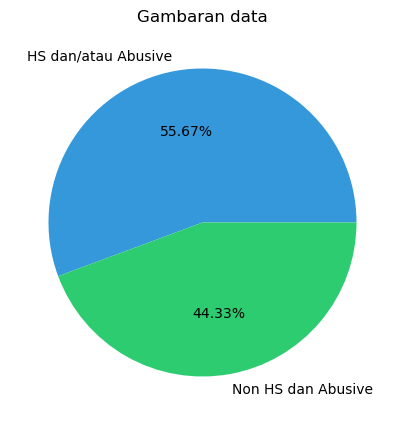

5783

In [27]:
#visualisasi untuk membaca HS dan abusive
total_data = len(df_data_an)
jumlah_non_hs_and_non_abusive = ((df_data_an['HS'] == 0) & (df_data_an['Abusive'] == 0)).sum()
HS_Abusive = total_data-jumlah_non_hs_and_non_abusive

labels = ['HS dan/atau Abusive', 'Non HS dan Abusive']
sizes = [HS_Abusive, jumlah_non_hs_and_non_abusive]
colors = ['#3498db', '#2ecc71']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', colors=colors)
plt.title('Gambaran data')
plt.show()
jumlah_non_hs_and_non_abusive

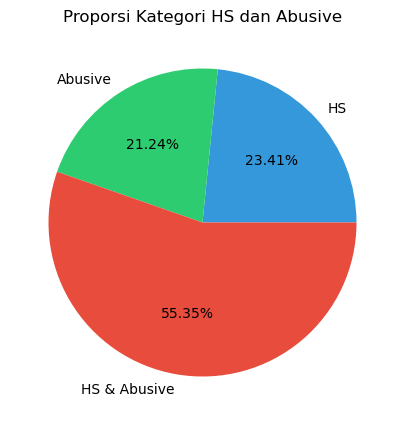

In [28]:
total_data = len(df_data_an)
jumlah_hs = df_data_an['HS'].sum()
jumlah_abusive = df_data_an['Abusive'].sum()
jumlah_hs_and_abusive = ((df_data_an['HS'] == 1) & (df_data_an['Abusive'] == 1)).count()

labels = ['HS', 'Abusive', 'HS & Abusive']
sizes = [jumlah_hs, jumlah_abusive, jumlah_hs_and_abusive]
colors = ['#3498db', '#2ecc71', '#e74c3c']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', colors=colors)
plt.title('Proporsi Kategori HS dan Abusive')
plt.show()

In [29]:
#hapus abusive dari kalimat
def hapus_abusive_dari_kalimat(kalimat, abusive_set, kata_dihapus):
    kata_kalimat = kalimat.lower().split()
    kata_tanpa_abusive = [kata for kata in kata_kalimat if kata not in abusive_set]
    kata_dihapus.extend([kata for kata in kata_kalimat if kata not in kata_tanpa_abusive])
    return ' '.join(kata_tanpa_abusive)

def hapus_abusive_dari_dataframe(df, abusive_set):
    kata_dihapus = []
    df['Tweet_cleaned'] = df['Tweet'].apply(lambda x: hapus_abusive_dari_kalimat(x, abusive_set, kata_dihapus))
    df_kata_dihapus = pd.DataFrame.from_dict(Counter(kata_dihapus), orient='index', columns=['Jumlah']).reset_index()
    df_kata_dihapus = df_kata_dihapus.rename(columns={'index': 'Kata'})
    return df, df_kata_dihapus

abusive_set = set(df_abussive_an['ABUSIVE'].str.lower().values)
df_data_an_cleaned, df_kata_dihapus = hapus_abusive_dari_dataframe(df_data_an, abusive_set)
all_text = ' '.join(df_data_an_cleaned['Tweet_cleaned'].str.cat(sep=' ').split())

print("----------------")
print(df_kata_dihapus)

----------------
          Kata  Jumlah
0         bego     118
1         edan      59
2        sarap      66
3        sipit     177
4       cebong     515
..         ...     ...
113     serbet       5
114    ngaceng      10
115      porno       2
116  panasbung       5
117  berengsek       1

[118 rows x 2 columns]


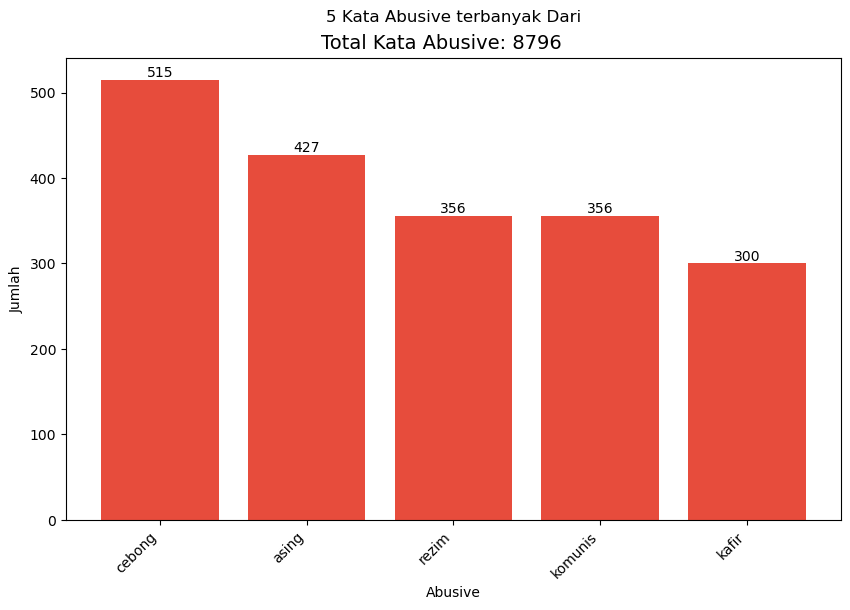

In [30]:
df_kata_dihapus = df_kata_dihapus.sort_values(by='Jumlah', ascending=False)
#5 data teratas
df_kata_dihapus_top10 = df_kata_dihapus.head(5)

plt.figure(figsize=(10, 6))
plt.bar(df_kata_dihapus_top10['Kata'], df_kata_dihapus_top10['Jumlah'], color='#e74c3c')
plt.xlabel('Abusive')
plt.ylabel('Jumlah')
plt.title('5 Kata Abusive terbanyak Dari', y=1.06)
plt.xticks(rotation=45, ha='right')

for i, value in enumerate(df_kata_dihapus_top10['Jumlah']):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.suptitle(f"Total Kata Abusive: {df_kata_dihapus['Jumlah'].sum()}", fontsize=14, y=0.92)
plt.show()

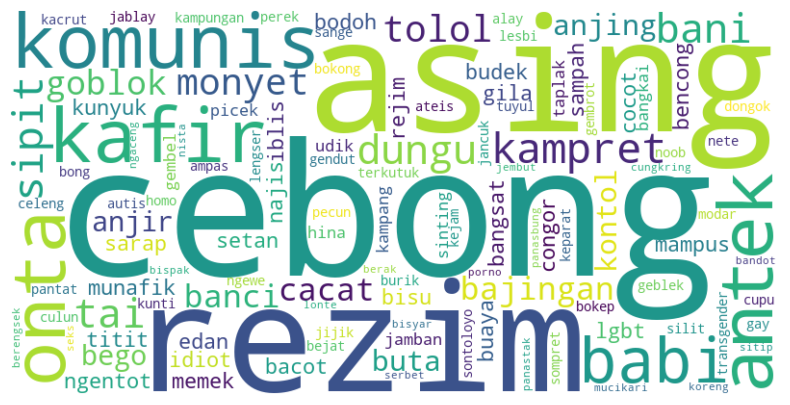

In [31]:
kata_dihapus_text = ' '.join(df_kata_dihapus['Kata'].astype(str))
wordcloud_kata_dihapus = WordCloud(width=800, height=400, background_color='white').generate(kata_dihapus_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_kata_dihapus, interpolation='bilinear')
plt.axis('off')

plt.show()

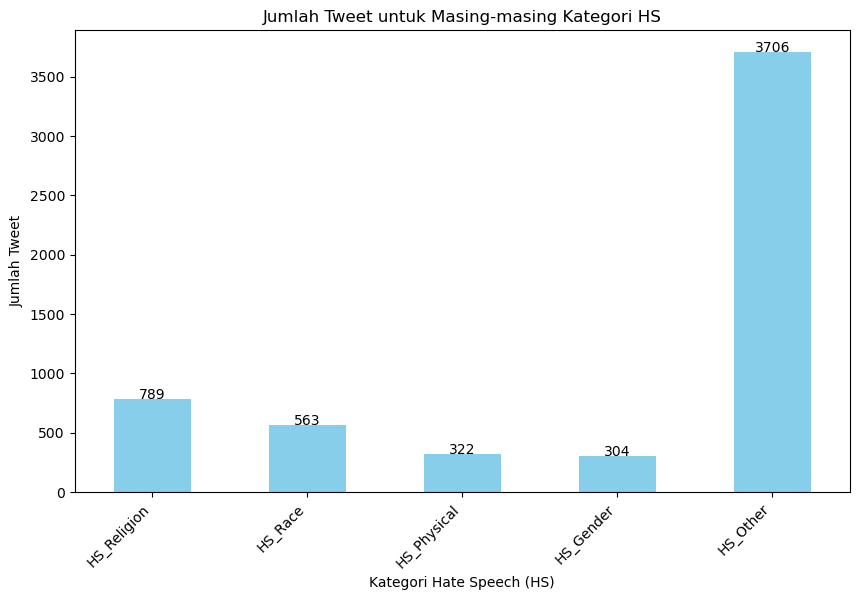

In [32]:
subset_columns = ['HS_Religion','HS_Race','HS_Physical','HS_Gender','HS_Other']
subset_df = df_data_an[subset_columns]
plt.figure(figsize=(10, 6))
ax = subset_df.sum().plot(kind='bar', color='skyblue')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.title('Jumlah Tweet untuk Masing-masing Kategori HS')
plt.xlabel('Kategori Hate Speech (HS)')
plt.ylabel('Jumlah Tweet')
plt.xticks(rotation=45, ha='right') 
plt.show()

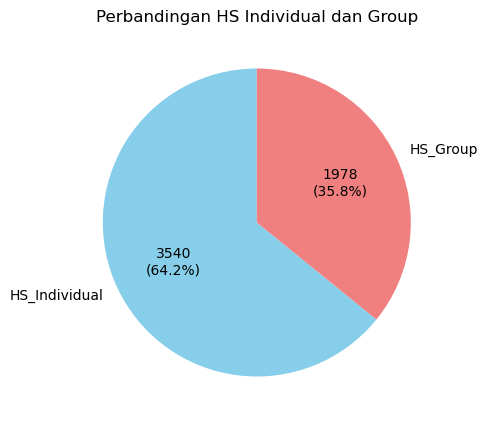

In [33]:
subset_columns = ['HS_Individual', 'HS_Group']
subset_df = df_data_an[subset_columns]

plt.figure(figsize=(5, 5))
ax = subset_df.sum().plot(kind='pie', autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(subset_df.sum()) / 100, p),
                          startangle=90, colors=['skyblue', 'lightcoral'])

plt.title('Perbandingan HS Individual dan Group')
plt.ylabel('')

plt.show()


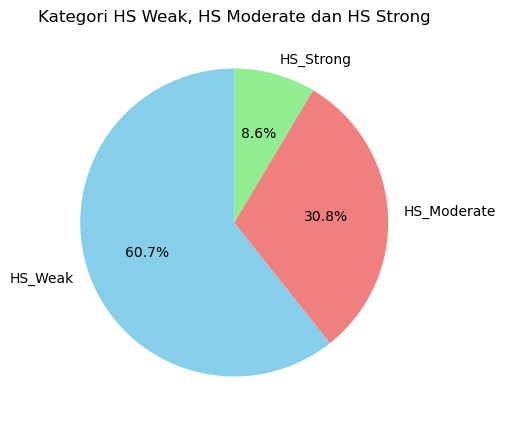

In [34]:
subset_columns = ['HS_Weak', 'HS_Moderate', 'HS_Strong']
subset_df = df_data_an[subset_columns]

#hitung jumlah tweet masing-masing kategori
category_counts = subset_df.sum()

plt.figure(figsize=(5, 5))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Kategori HS Weak, HS Moderate dan HS Strong')
plt.show()

In [35]:
#dataframe baru untuk masing-masing HS_Strong, HS_Weak, dan HS_Moderate bernilai 1
condition_strong = df_data_an['HS_Strong'] == 1
condition_weak = df_data_an['HS_Weak'] == 1
condition_moderate = df_data_an['HS_Moderate'] == 1


df_strong = df_data_an.loc[condition_strong]
df_weak = df_data_an.loc[condition_weak]
df_moderate = df_data_an.loc[condition_moderate]


column_counts_strong = df_strong[['HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']].sum()
column_counts_weak = df_weak[['HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']].sum()
column_counts_moderate = df_moderate[['HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']].sum()


column_counts_strong_sorted = column_counts_strong.sort_values(ascending=False)
column_counts_weak_sorted = column_counts_weak.sort_values(ascending=False)
column_counts_moderate_sorted = column_counts_moderate.sort_values(ascending=False)


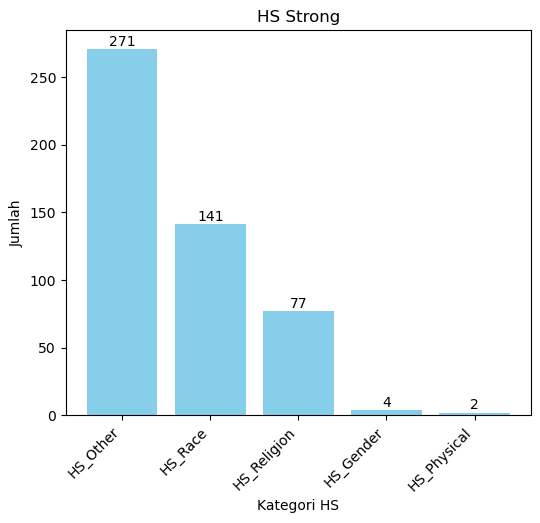

In [36]:
#plot bar HS_Strong
plt.figure(figsize=(6, 5))
plt.bar(column_counts_strong_sorted.index, column_counts_strong_sorted, color='skyblue')
plt.title('HS Strong')
plt.xlabel('Kategori HS')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(column_counts_strong_sorted):
    plt.text(i, value + 0.1, '{:.0f}'.format(value), ha='center', va='bottom')
plt.show()

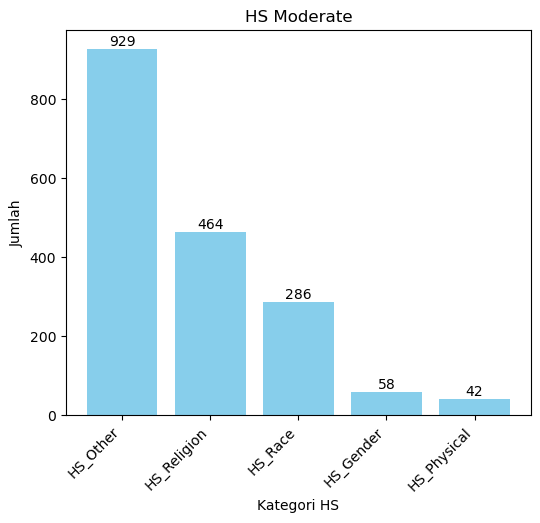

In [37]:
#plot HS Moderate
plt.figure(figsize=(6, 5))
plt.bar(column_counts_moderate_sorted.index, column_counts_moderate_sorted, color='skyblue')
plt.title('HS Moderate')
plt.xlabel('Kategori HS')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(column_counts_moderate_sorted):
    plt.text(i, value + 0.1, '{:.0f}'.format(value), ha='center', va='bottom')
plt.show()

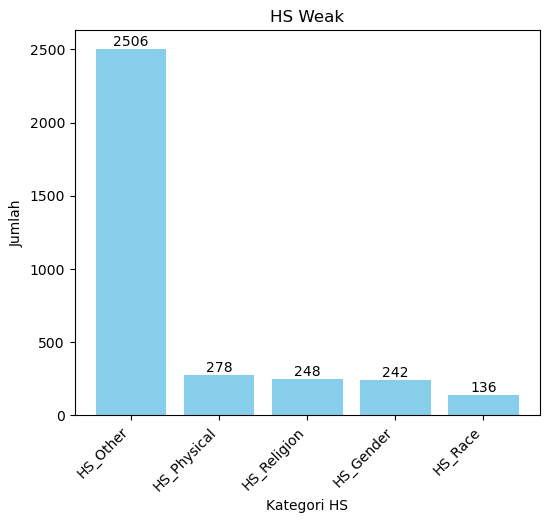

In [38]:
#plot bar HS_Weak
plt.figure(figsize=(6, 5))
plt.bar(column_counts_weak_sorted.index, column_counts_weak_sorted, color='skyblue')
plt.title('HS Weak')
plt.xlabel('Kategori HS')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(column_counts_weak_sorted):
    plt.text(i, value + 0.1, '{:.0f}'.format(value), ha='center', va='bottom')
plt.show()